In [1]:
!nvidia-smi

Fri Feb 10 07:05:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -U gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!gdown 1_U7CV-rix9W2vixsxTxoSpNwaKwjpy9e

Downloading...
From: https://drive.google.com/uc?id=1_U7CV-rix9W2vixsxTxoSpNwaKwjpy9e
To: /content/mini-ImageNet64x64.zip
100% 572M/572M [00:03<00:00, 163MB/s]


In [4]:
!unzip -qq mini-ImageNet64x64.zip

replace mini-ImageNet64x64/train/22/119.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from tqdm.autonotebook import tqdm

import os

# [실습 Challenge] Classifying 'mini-ImageNet'

- 평가 기준: mini-ImageNet 데이터셋의 test accuracy
- 트레이닝 과정에서 어떤 방식으로든 퍼래미터 업데이트에 테스트 데이터가 관여되는 경우 0점 처리됩니다. 특히 BatchNorm이나 Dropout 사용시 test set evaluation 전에 `model.eval()`을 사용하셔야 합니다.
- 아래 `final_evaluation` 함수 역시 수정시 0점 처리 됩니다.
- 데이터셋의 특성상 pretrained model의 사용은 허용되지 않습니다.
- 조교의 평가 환경(Titan Xp 12GB)에서 실행할 수 있는 모델 규모를 초과하면 안 됩니다.
- PyTorch, NumPy로 구현하셔야 하고, TensorFlow 등으로 구현 시 0점 처리됩니다.


## Dataset overview
* 50,000 images for train, 10,000 images for test (.png format)
* 100 classes (500/100 train/test images per class)
* mini-ImageNet is subset of ImageNet, with smaller image size. It was originally designed to be used for few-shot learning evaluation, but we will use it for image classification in this challenge.
* 64x64 RGB images


In [4]:
device = 'cuda'
log_dir = 'log/mini-imagenet'
batch_size = 64
num_workers = 4
lr = 1e-3
momentum = 0.9
weight_decay = 1e-3
epoch = 20
n_steps = 10000

In [5]:
from torch.utils.data import DataLoader, RandomSampler

# Data transformation of train and test data
data_transforms = {
    'train': transforms.Compose([
        # build your own transforms
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomCrop(64),
        transforms.RandomRotation(0.4),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]),
}

train_dataset = datasets.ImageFolder('mini-ImageNet64x64/train', transform=data_transforms['train'])
test_dataset = datasets.ImageFolder('mini-ImageNet64x64/test', transform=data_transforms['test'])

sampler = RandomSampler(train_dataset,
                        replacement=True,
                        num_samples=batch_size * n_steps)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              sampler=sampler, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=num_workers)


print(len(train_dataset)) # b , 3, 64, 64
print(len(test_dataset))


50000
10000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# import numpy as np
# def calculate_normalization_params(train_loader, test_loader):
#     chan0 = np.array([])
#     chan1 = np.array([])
#     chan2 = np.array([])
    
#     for i, data in tqdm(enumerate(train_loader, 0)):
#         images, _ = data
#         chan0 = np.concatenate((chan0, images[:, 0, :, :].cpu().flatten()))
#         chan1 = np.concatenate((chan0, images[:, 1, :, :].cpu().flatten()))
#         chan2 = np.concatenate((chan0, images[:, 2, :, :].cpu().flatten()))
        
#     means = [np.mean(chan0), np.mean(chan1), np.mean(chan2)]
#     stds  = [np.std(chan0), np.std(chan1), np.std(chan2)]
    
#     return means, stds


# train_transform = transforms.Compose([transforms.ToTensor()])
# test_transform = transforms.Compose([transforms.ToTensor()])

# train_dataset = datasets.ImageFolder('mini-ImageNet64x64/train', transform=train_transform)
# test_dataset = datasets.ImageFolder('mini-ImageNet64x64/test', transform=test_transform)

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
#                               shuffle=True, num_workers=num_workers)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
#                              shuffle=True, num_workers=num_workers)

# means, stds = calculate_normalization_params(train_dataloader,test_dataloader)
# print(f'means: {means}')
# print(f'stds: {stds}')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Size of train set: 50000
Input shape: torch.Size([3, 64, 64])
Label: 24


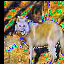

In [6]:
# Let's take a look at train dataset
print(f"Size of train set: {len(train_dataset)}")
index = 12345
x, y = train_dataset[index]
print(f"Input shape: {x.shape}")
print(f"Label: {y}")
transforms.functional.to_pil_image(x)

## Model

In [15]:
# Minimal MLP implementation
# DO NOT CHANGE Model name

class block(nn.Module):
    def __init__(self, dim_1, dim_2, stride=1):
        super(block, self).__init__()
        self.conv1 = nn.Conv2d(dim_1, dim_2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(dim_2)
        self.conv2 = nn.Conv2d(dim_2, dim_2, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(dim_2)

        self.shortcut = nn.Sequential()
        if stride != 1 or dim_1 != dim_2:
            self.shortcut = nn.Sequential(
                nn.Conv2d(dim_1, dim_2, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(dim_2)
            )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)  



    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Model(nn.Module):
    def __init__(self, num_classes=100):
        super(Model, self).__init__()
        self.in_dim = 32

        self.conv1 = nn.Conv2d(3, self.in_dim, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_dim)
        self.layer1 = self._make_layer(32*2, 2, stride=1)
        self.layer2 = self._make_layer(32*4, 2, stride=2)
        self.layer3 = self._make_layer(32*8, 2, stride=2)
        self.layer4 = self._make_layer(32*8, 2, stride=2)
        self.layer5 = self._make_layer(32*16, 2, stride=2)

        self.clf = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)), 
                                        nn.Flatten(), 
                                        nn.Linear(32*16, num_classes),
                                        nn.LogSoftmax(dim=-1))

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_dim, planes, stride))
            self.in_dim = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.clf(out)

        return out


In [16]:
Model()

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): block(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [17]:
import numpy as np
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model = model
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
            self.best_score = score
            return self.best_model
        else:
            print(f'Validation loss decreased ({-self.best_score:.6f} --> {val_loss:.6f}).')
            self.best_score = score
            self.best_model = model
            # self.save_checkpoint(val_loss, model)
            self.counter = 0
            return self.best_model

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## Train

In [18]:
model = Model()
early_stopping = EarlyStopping(patience=5, verbose=True)
best_model = None
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
writer = SummaryWriter(log_dir)

model = model.to(device)

for step, (x, y) in enumerate(tqdm(train_dataloader), start=1):
    model.train()
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    # Summary & Eval
    if step % 500 == 0:
        
        total, correct = 0, 0
        test_loss = 0
        model.eval()
        for x, y in tqdm(test_dataloader, leave=False):
            x, y = x.to(device), y.to(device)

            # Don't compute gradient during evaluation
            with torch.no_grad():
                pred = model(x)

            test_loss += criterion(pred, y) * x.shape[0]

            total += x.shape[0]
            correct += (pred.max(dim=1)[1] == y).sum()

        test_loss /= total
        accuracy = correct / total
        writer.add_scalar('loss/train', loss.detach(), step)
        writer.add_scalar('loss/test', test_loss, step)
        writer.add_scalar('accuracy', accuracy, step)

        print(f"[Step {step}] train_loss: {loss.detach().squeeze():.2f}, test_loss: {test_loss:.2f}, test_accuracy: {accuracy:.4f}")

        best_model = early_stopping(test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
model = best_model

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

[Step 500] train_loss: 3.70, test_loss: 3.67, test_accuracy: 0.1321
Validation loss decreased (inf --> 3.671941).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 1000] train_loss: 3.24, test_loss: 3.34, test_accuracy: 0.1895
Validation loss decreased (3.671941 --> 3.337918).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 1500] train_loss: 3.35, test_loss: 3.57, test_accuracy: 0.1443
EarlyStopping counter: 1 out of 5


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 2000] train_loss: 2.88, test_loss: 2.95, test_accuracy: 0.2637
Validation loss decreased (3.565968 --> 2.954817).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 2500] train_loss: 2.31, test_loss: 2.54, test_accuracy: 0.3511
Validation loss decreased (2.954817 --> 2.542424).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 3000] train_loss: 3.30, test_loss: 3.39, test_accuracy: 0.2109
EarlyStopping counter: 1 out of 5


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 3500] train_loss: 2.71, test_loss: 2.87, test_accuracy: 0.2802
Validation loss decreased (3.392663 --> 2.868166).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 4000] train_loss: 2.22, test_loss: 2.55, test_accuracy: 0.3417
Validation loss decreased (2.868166 --> 2.550581).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 4500] train_loss: 2.36, test_loss: 2.26, test_accuracy: 0.4125
Validation loss decreased (2.550581 --> 2.261573).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 5000] train_loss: 1.91, test_loss: 2.09, test_accuracy: 0.4495
Validation loss decreased (2.261573 --> 2.090411).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 5500] train_loss: 2.49, test_loss: 2.90, test_accuracy: 0.2860
EarlyStopping counter: 1 out of 5


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 6000] train_loss: 2.11, test_loss: 2.86, test_accuracy: 0.3030
Validation loss decreased (2.904266 --> 2.855076).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 6500] train_loss: 2.04, test_loss: 2.56, test_accuracy: 0.3461
Validation loss decreased (2.855076 --> 2.564984).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 7000] train_loss: 2.51, test_loss: 2.38, test_accuracy: 0.3860
Validation loss decreased (2.564984 --> 2.384404).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 7500] train_loss: 1.84, test_loss: 2.19, test_accuracy: 0.4290
Validation loss decreased (2.384404 --> 2.194704).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 8000] train_loss: 1.75, test_loss: 2.16, test_accuracy: 0.4426
Validation loss decreased (2.194704 --> 2.159507).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 8500] train_loss: 2.23, test_loss: 1.99, test_accuracy: 0.4762
Validation loss decreased (2.159507 --> 1.989298).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 9000] train_loss: 1.44, test_loss: 1.85, test_accuracy: 0.5113
Validation loss decreased (1.989298 --> 1.845275).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 9500] train_loss: 1.23, test_loss: 1.75, test_accuracy: 0.5342
Validation loss decreased (1.845275 --> 1.748755).


  0%|          | 0/157 [00:00<?, ?it/s]

[Step 10000] train_loss: 1.21, test_loss: 1.71, test_accuracy: 0.5427
Validation loss decreased (1.748755 --> 1.712607).


## Evaluation

In [19]:
def predict(x):
    x = x.to(device)
    
    with torch.no_grad():
        # You can modify this part if necessary
        pred = model(x)
        
    return pred.max(dim=1)[1].to('cpu')

In [20]:
# DO NOT MODIFY `final_evaluation()`
def final_evaluation():
    model.eval()
    correct = 0
    for x, y in test_dataloader:
        correct += (predict(x) == y).sum()
    accuracy = correct / len(test_dataset)
    print(f"FINAL ACCURACY: {accuracy:.4f}")
    
final_evaluation()

FINAL ACCURACY: 0.5427


## Submission
* 마감: 2/10 (Fri) 5:30 pm
* 제출 방법
    - <jihwan.moon@vision.snu.ac.kr>, <junseo.koo@vision.snu.ac.kr> **둘 다로** 본 노트북 파일의 이름을 `본인이름.ipynb`로 바꿔 제출. ex) `홍길동.ipynb`
    - 이메일 제목: 본인 이름과 Final accuracy를 소수점 넷째 자리까지 포함하여 보내주세요. `딥러닝_프로젝트_홍길동_0.2389`
    - 최종적으로 실행한 히스토리를 지우지 말고 그대로 유지해주세요. 최종 성능은 메일 제목의 성능과 같아야 합니다.
    - 조교가 노트북 전체를 **처음부터 실행했을 때**, 학습 결과가 재현되어야 합니다. (재현되지 않을 시 0점 처리 될 수 있습니다.)
    - `final_evaluation()` 함수는 수정하지 말고, 실행 결과만 포함시켜주세요

In [ ]:
# 수고많으셨습니다!